In [ ]:
import joblib
import numpy as np
import joblib
import numpy as np
import networkx as nx
import yaml
import utilities as ut 
import opt_tools as optools
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'lilucas'

In [3]:
config_files = {
                    'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
                    'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
                    'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
                }
configs = ut.load_configs(config_files)

hyperparams_diroca = configs['hyperparams_diroca']
hyperparams_gradca = configs['hyperparams_gradca']
hyperparams_baryca = configs['hyperparams_baryca']

In [4]:
all_data   = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

Dll_obs     = all_data['LLmodel']['data'][None]
Dhl_obs     = all_data['HLmodel']['data'][None]
folds_path  = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'], hyperparams_diroca['seed'], folds_path)

Data loaded for 'lilucas'.
Created and saved 2 folds to 'data/lilucas/cv_folds.pkl'


In [5]:
# --- The Main Optimization and Evaluation Loop ---
diroca_cv_results = {}

# Iterate through each cross-validation fold
for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Cross-Validation for Fold {i+1}/{len(saved_folds)} ---")
    
    # Create a new sub-dictionary for the current fold
    fold_key = f'fold_{i}'
    diroca_cv_results[fold_key] = {}
    
    # Determine the fold-specific radius bound
    train_n = len(fold_info['train'])
    ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    eps_delta_values = [4, 8]

    # Iterate through each radii value
    for eps_delta in eps_delta_values:
        print(f"  - Training for ε=δ = {eps_delta}")

        # Assemble parameters for this specific run
        params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_diroca)
        params_for_this_run['theta_hatL']['radius'] = eps_delta
        params_for_this_run['theta_hatH']['radius'] = eps_delta
        
        opt_args = params_for_this_run.copy()
        opt_args.pop('k_folds', None)
        
        # Run the optimization
        trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)
        
        # Store the results 
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'test_indices': fold_info['test'],
            'monitor': monitor
        }

print("\n\n--- Optimization Complete ---")


--- Starting Cross-Validation for Fold 1/2 ---
  - Training for ε=δ = 4


 42%|████▏     | 838/2000 [04:11<05:49,  3.33it/s]


T contains NaN! Returning previous matrix.
Failed at step: 2
NaN encountered during optimization. Returning last valid state.


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
print('went to see kible 13.12!')

went to see kible!


In [ ]:
print('done!!!!')

In [7]:
fold_to_inspect = 'fold_0'
hyperparam_to_inspect = 'eps_delta_8' # Use a key that exists in your results

result = diroca_cv_results[fold_to_inspect][hyperparam_to_inspect]
monitor = result['monitor']

fold_info = saved_folds[int(fold_to_inspect.split('_')[1])]

initial_params = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_diroca)

initial_params_L = initial_params['theta_hatL']
initial_params_H = initial_params['theta_hatH']

final_params = result['optimization_params']



--- Distribution Summary: Low-Level Model ---

Mean (μ):
  - Initial: [0 0 0]
  - Final  : [ 0.142 -0.142  0.142]

Variances (diag(Σ)):
  - Initial: [1 1 1]
  - Final  : [6.678 0.534 4.761]

Final Correlation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
----------------------------------------


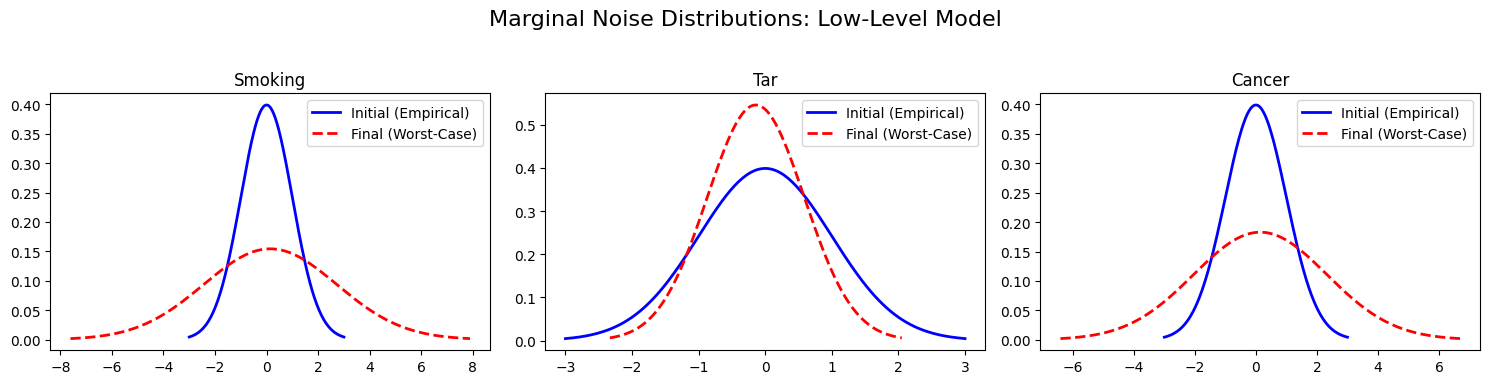


--- Distribution Summary: High-Level Model ---

Mean (μ):
  - Initial: [0.02 0.  ]
  - Final  : [0.162 0.142]

Variances (diag(Σ)):
  - Initial: [8.601 0.239]
  - Final  : [7.628 7.628]

Final Correlation Matrix:
[[1. 0.]
 [0. 1.]]
-----------------------------------------


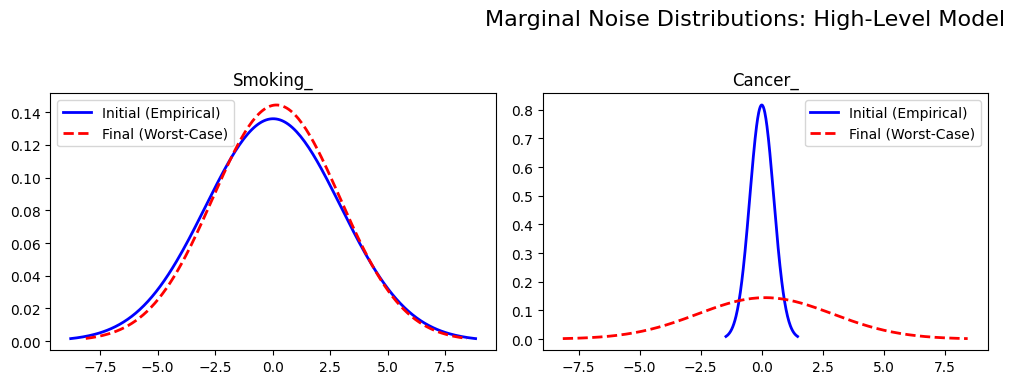

In [8]:
# Print the Numerical Summary for both LL and HL models and plot the marginal distributions
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

ut.print_distribution_summary(final_params['L'], initial_params_L, name="Low-Level Model")
ut.plot_marginal_distributions(final_params['L'], initial_params_L, ll_var_names, model_name="Low-Level Model")


ut.print_distribution_summary(final_params['H'], initial_params_H, name="High-Level Model")
ut.plot_marginal_distributions(final_params['H'], initial_params_H, hl_var_names, model_name="High-Level Model")

Total Trajectory Length (Low-Level): 5.1827
Distribution Spread (Low-Level): μ-Spread=0.0051, Σ-Spread=0.9416


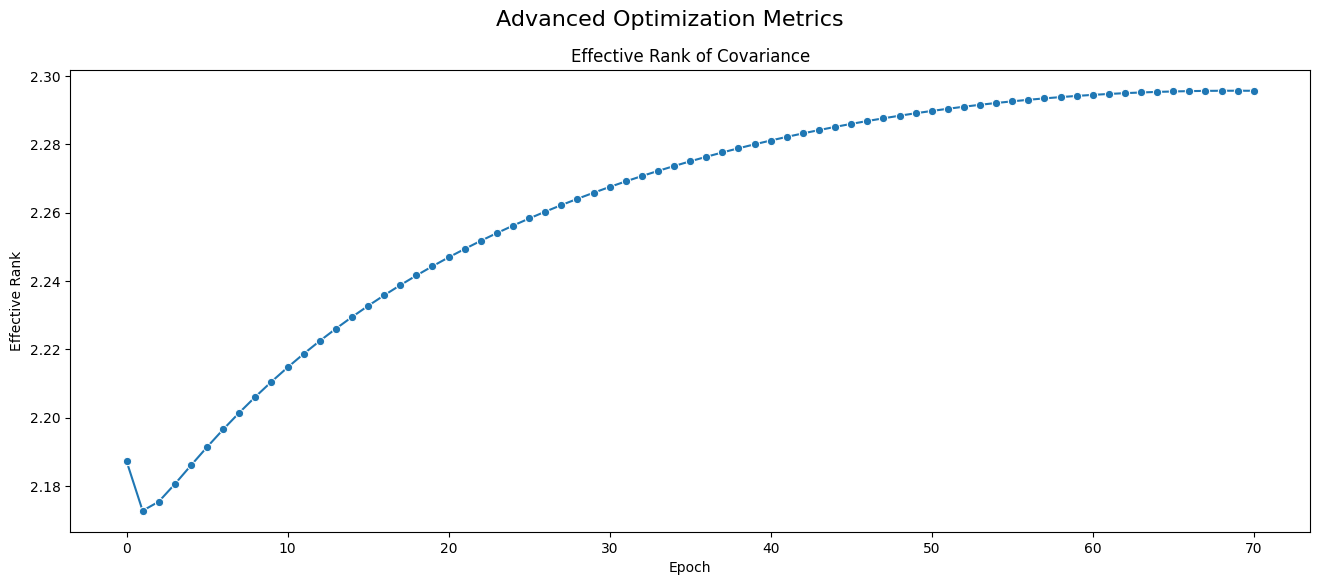

In [9]:
# Metric 1: Trajectory Length
traj_len = monitor.compute_trajectory_length(level='L')
print(f"Total Trajectory Length (Low-Level): {traj_len:.4f}")

# Metric 2: Diversity/Spread
spreads = monitor.compute_spread_metrics(level='L')
print(f"Distribution Spread (Low-Level): μ-Spread={spreads['spread_mu']:.4f}, Σ-Spread={spreads['spread_sigma']:.4f}")

# Metric 3: Effective Rank of Covariance
eff_ranks = monitor.compute_effective_rank_history(level='L')

fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle('Advanced Optimization Metrics', fontsize=16)

sns.lineplot(x=range(len(eff_ranks)), y=eff_ranks, marker='o', ax=ax)
ax.set_title('Effective Rank of Covariance')
ax.set_xlabel('Epoch')
ax.set_ylabel('Effective Rank')

plt.show()

In [9]:
# ll_var_names = list(all_data['LLmodel']['graph'].nodes())
# ut.create_optimization_animation(monitor, initial_params, ll_var_names, model_level='L', filename='ll_optimization.gif')

# hl_var_names = list(all_data['HLmodel']['graph'].nodes())
# ut.create_optimization_animation(monitor, initial_params, hl_var_names, model_level='H', filename='hl_optimization.gif')

### 2. GRADCA optimization

In [10]:
gradca_cv_results = {}

# 2. Outer Loop: Iterate through each cross-validation fold
for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Cross-Validation for Fold {i+1}/{len(saved_folds)} ---")
    
    # Create a new sub-dictionary for the current fold
    fold_key = f'fold_{i}'
    gradca_cv_results[fold_key] = {}
    
    # Determine the fold-specific radius bound
    train_n = len(fold_info['train'])

    # Assemble parameters for this specific run
    params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_gradca)
   
    # Prepare arguments for the optimization function
    opt_args = params_for_this_run.copy()
    opt_args.pop('k_folds', None)
    
    # Run the optimization
    trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)

    # Store the results
    gradca_cv_results[fold_key] = {
        'gradca_run': {
            'T_matrix': trained_T,
            'test_indices': fold_info['test'] 
        }
    }
    
print("\n\n--- Optimization Complete ---")


--- Starting Cross-Validation for Fold 1/2 ---


 66%|██████▋   | 1327/2000 [00:15<00:07, 86.30it/s]


Convergence reached at epoch 1328 with objective 0.026051202788949013

--- Starting Cross-Validation for Fold 2/2 ---


 66%|██████▋   | 1327/2000 [00:15<00:07, 86.09it/s]

Convergence reached at epoch 1328 with objective 0.026051202788949013


--- Optimization Complete ---


### 3. BARYCA optimization

In [11]:
baryca_cv_results = {}

for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Barycentric Optimization for Fold {i+1}/{len(saved_folds)} ---")
    
    opt_args = ut.assemble_barycentric_parameters(fold_info, all_data, hyperparams_baryca)
    opt_args.pop('k_folds', None)

    # Run the optimization
    trained_params, trained_T = optools.barycentric_optimization(**opt_args)
    
    # Store the results 
    fold_key = f'fold_{i}'

    # Store the results
    baryca_cv_results[fold_key] = {
        'baryca_run': {
            'T_matrix': trained_T,
            'test_indices': fold_info['test'] 
        }
    }
print("\n\n--- Optimization Complete ---")


--- Starting Barycentric Optimization for Fold 1/2 ---

--- Starting Barycentric Optimization for Fold 2/2 ---


--- Optimization Complete ---


## Save the results

In [13]:
joblib.dump(diroca_cv_results, f"data/{experiment}/diroca_cv_results.pkl")
joblib.dump(gradca_cv_results, f"data/{experiment}/gradca_cv_results.pkl")
joblib.dump(baryca_cv_results, f"data/{experiment}/baryca_cv_results.pkl")

print("All results have been saved successfully!")

All results have been saved successfully!


In [ ]:
print('Done!')

Done!
